<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

# Vantage Analytic Library Demo Notebook 3 

</header>

## Note: You must have the Vantage Analytic Library (VAL) XSP, including the tutorial data, installed in order to run this notebook. You must also be able create the Analytic Data Set (ADS) table in the database where VAL is installed.

## Analytic Algorithms and Scoring

The following functions are currently available in the Vantage Analytic Library XSP release 2.0.

### Matrix Building

Matrix Building builds a sum-of-squares-and-cross-products (SSCP) matrix or other derived matrix type from a table in a Teradata Database. Matrix Building does this by generating and running the SQL to call
the Teradata CALCMATRIX table operator.  The resulting matrix can be (re)used by Linear Regression or Factor analysis.

### Linear Regression

Linear Regression is one of the fundamental types of predictive modeling algorithms. In linear regression, a dependent numeric variable is expressed in terms of the sum of one or more independent numeric variables, which are each multiplied by a numeric coefficient, usually with a constant term added to the sum of independent variables. Linear Regression consists of the coefficients of the independent variables together with a constant term that comprise a linear regression model. Applying these coefficients to the variables (columns) of each observation (row) in a data set (table) is known as scoring.  

### Factor Analysis - PCA

Factor Analysis is one of the most fundamental types of statistical analysis, and Principal Components Analysis (PCA), is arguably the most common variety of Factor Analysis.  In Factor Analysis, a set of variables (in this case columns) is reduced to a smaller number of factors that account for most of the variance in the variables.  This can be useful in reducing the number of variables by converting them to factors, or in gaining insight into the nature of the variables when they are used for further data analysis. Additionally, the Factor Analysis scoring process expresses each factor as a linear combination of the input columns.   The score output table contains one or more index (key) columns and factor score columns, one for each factor.

### Logistic Regression

Logistic Regression is one of the most widely used types of statistical analysis.  In Logistic Regression, a set of independent variables (in this case columns) is processed to predict the value of a dependent variable (column) that assumes two values referred to as response (1) and non-response (0).  Actually, the user specifies what value of the dependent variable to treat as the response, and all other values assumed by the depedent variable are treated as non-repsonse.  The result is not however a continuous numeric variable as seen in Linear Regression, but rather a probability between 0 and 1 that the response value is assumed by the dependent variable.

### Decision Trees

Currently, the Teradata Warehouse Miner External Stored Procedure provides decision trees for classification models. They are built largely on the techniques described in [Quinlan] and as such, splits using information gain ratio are provided. Pruning is also provided, also using the gain ratio technique. The concept of Information gain ratio is simple - the more you know about a topic, the less new information you are apt to get about it. To be more concise: If you know an event is very probable, it is no surprise when it happens - that is, it gives you little information that it actually happened.  Taking this a bit further, we can formulate that the amount of information gained is inversely proportional to the probability of an event happening. Given that entropy refers to the probability of an event occuring, we can also say that as the entropy increases, the information gain decreases. A decision tree scoring function is provided to score and/or evaluate a decision tree model. 

### K-Means Clustering

The task of modeling multidimensional data sets encompasses a variety of statistical techniques, including that of ‘cluster analysis’. Cluster analysis is a statistical process for identifying homogeneous groups of data objects.  K-Means clustering is one of the simplest and popular unsupervised machine learning algorithms.  Unsupervised algorithms make inferences from datasets using only input without known, or labelled, outcomes.  The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.  A cluster refers to a collection of data points aggregated together because of certain similarities.  The algorithm requires as input a target number k, which refers to the number of centroids to identify in the dataset, where a centroid is the location representing the center of the cluster.  Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.  In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

### Association Rules/Sequence Analysis

Association Rules provide various measures concerning items residing in groups.  The measures, support, confidence, lift and Z Score, help to determine the likelihood that one or more items exist in a group, given that another one or more items exist in the same group.  The classic example of this type of study is market basket analysis, in which the groups are shopping carts and the items are the products purchased in the shopping carts.  A sequence analysis may be optionally requested, wherein the sequence of items matters, ordering the items on each side of each rule, with left side items preceding the right side items.  


## Vantage Analytic Library - Call Structure

call ${XSPDB}.td_analyze('\<function name\>','\<database=database name\>;\<tablename=table name\>;\<columns=column1, column2\>,'\<param1\>=\<value1\>;\<param2\>=\<value2\>...');

---

You will need to create a connection to your Vantage system and sign on with your credentails. First we setup variables that you will need to change as follows.

1) First, setup the variable SystemName and host for the system to connect to.

In [ ]:
%var SystemName=<Your system name>, Host=<Host name or IP address>

2) Next change QLID below to be equal to the username you use to log into your Vantage system. Your data lab will be the result database for all VAL calls where any output tables or views are created.  

In [ ]:
%var QLID=<Your login id>

3) The next variable MUST bet set to the database where the Vantage Analytic Library and tutorial data has been installed.

In [ ]:
%var XSPDB=<Your Library database>

---

Now, add the connection and connect to the system you have specified in the variable "SystemName" above.

In [ ]:
%addconnect Name=${SystemName}, Host=${Host} 

In [ ]:
%connect ${SystemName}, hidewarnings=true

Change focus to the database specified by the variable "XSPDB" above.

In [ ]:
DATABASE ${XSPDB};

### Demo data - Financial Customers/Accounts/Transactions

This notebook assumes the following tutorial data has been loaded into the ${XSPDB} database.  Its a simplistic ficticiouss dataset of banking customers (1K-ish rows), Accounts (10K-ish rows) and Transactions (100K-ish rows).  They are related to each other in the following ways:

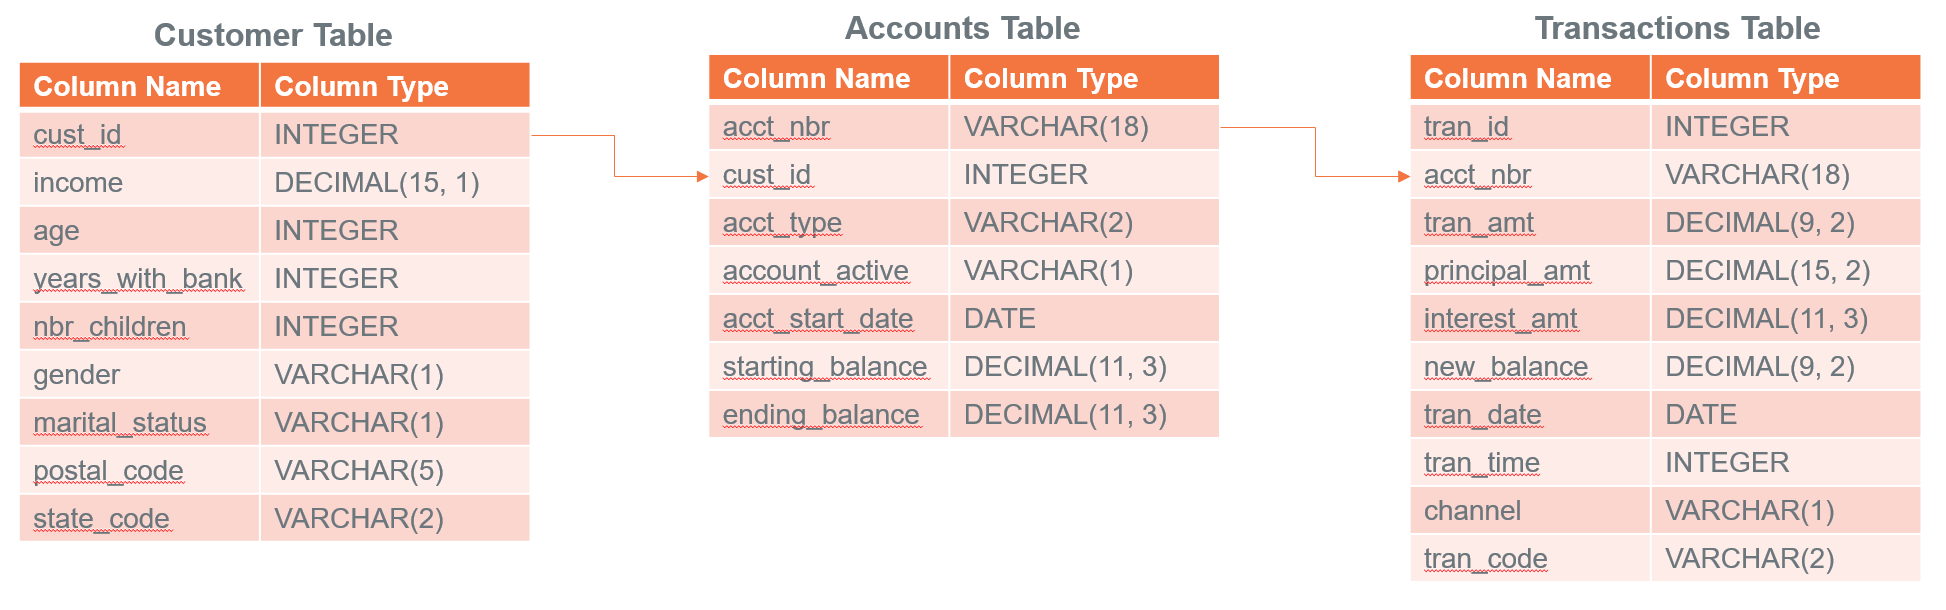

In [ ]:
SELECT * FROM ${XSPDB}.Customer SAMPLE 10;

In [ ]:
%meta

In [ ]:
SELECT * FROM ${XSPDB}.Accounts SAMPLE 10;

In [ ]:
%meta

In [ ]:
SELECT * FROM ${XSPDB}.Transactions SAMPLE 10;

In [ ]:
%meta

Create the following Analytic Data Set (ADS) by joining all three tables above.  You must have CREATE TABLE permissions on the Database where the Vantage Analytic Library is installed.

In [ ]:
CREATE TABLE ${XSPDB}.VAL_ADS AS (
    SELECT 
        T1.cust_id  AS cust_id
       ,MIN(T1.income) AS tot_income
       ,MIN(T1.age) AS tot_age
       ,MIN(T1.years_with_bank) AS tot_cust_years
       ,MIN(T1.nbr_children) AS tot_children
       ,CASE WHEN MIN(T1.marital_status) = 1 THEN 1 ELSE 0 END AS single_ind
       ,CASE WHEN MIN(T1.gender) = 'F' THEN 1 ELSE 0 END AS female_ind
       ,CASE WHEN MIN(T1.marital_status) = 2 THEN 1 ELSE 0 END AS married_ind
       ,CASE WHEN MIN(T1.marital_status) = 3 THEN 1 ELSE 0 END AS separated_ind
       ,MAX(CASE WHEN T1.state_code = 'CA' THEN 1 ELSE 0 END) AS ca_resident_ind
       ,MAX(CASE WHEN T1.state_code = 'NY' THEN 1 ELSE 0 END) AS ny_resident_ind
       ,MAX(CASE WHEN T1.state_code = 'TX' THEN 1 ELSE 0 END) AS tx_resident_ind
       ,MAX(CASE WHEN T1.state_code = 'IL' THEN 1 ELSE 0 END) AS il_resident_ind
       ,MAX(CASE WHEN T1.state_code = 'AZ' THEN 1 ELSE 0 END) AS az_resident_ind
       ,MAX(CASE WHEN T1.state_code = 'OH' THEN 1 ELSE 0 END) AS oh_resident_ind
       ,MAX(CASE WHEN T2.acct_type = 'CK' THEN 1 ELSE 0 END) AS ck_acct_ind
       ,MAX(CASE WHEN T2.acct_type = 'SV' THEN 1 ELSE 0 END) AS sv_acct_ind
       ,MAX(CASE WHEN T2.acct_type = 'CC' THEN 1 ELSE 0 END) AS cc_acct_ind
       ,AVG(CASE WHEN T2.acct_type = 'CK' THEN T2.starting_balance+T2.ending_balance ELSE 0 END) AS ck_avg_bal
       ,AVG(CASE WHEN T2.acct_type = 'SV' THEN T2.starting_balance+T2.ending_balance ELSE 0 END) AS sv_avg_bal
       ,AVG(CASE WHEN T2.acct_type = 'CC' THEN T2.starting_balance+T2.ending_balance ELSE 0 END) AS cc_avg_bal
       ,AVG(CASE WHEN T2.acct_type = 'CK' THEN T3.principal_amt+T3.interest_amt ELSE 0 END) AS ck_avg_tran_amt
       ,AVG(CASE WHEN T2.acct_type = 'SV' THEN T3.principal_amt+T3.interest_amt ELSE 0 END) AS sv_avg_tran_amt
       ,AVG(CASE WHEN T2.acct_type = 'CC' THEN T3.principal_amt+T3.interest_amt ELSE 0 END) AS cc_avg_tran_amt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 1 THEN T3.tran_id ELSE NULL END) AS q1_trans_cnt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 2 THEN T3.tran_id ELSE NULL END) AS q2_trans_cnt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 3 THEN T3.tran_id ELSE NULL END) AS q3_trans_cnt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 4 THEN T3.tran_id ELSE NULL END) AS q4_trans_cnt
    FROM ${XSPDB}.Customer AS T1
        LEFT OUTER JOIN ${XSPDB}.Accounts AS T2
            ON T1.cust_id = T2.cust_id
        LEFT OUTER JOIN ${XSPDB}.Transactions AS T3
            ON T2.acct_nbr = T3.acct_nbr
GROUP BY T1.cust_id) WITH DATA UNIQUE PRIMARY INDEX (cust_id);

In [ ]:
SELECT * FROM ${XSPDB}.VAL_ADS SAMPLE 10;

In [ ]:
%meta

---

## Matrix Building

### Purpose

Matrix Building builds a sum-of-squares-and-cross-products (SSCP) matrix or other derived matrix type  from a table in a Teradata Database. Matrix Building does this by generating and running the SQL to call
the Teradata CALCMATRIX table operator provided in Teradata beginning with the 14.10 release. The results are stored either in a table or as a result set returned to the user. The purpose in building a matrix
depends on the type of matrix built. For example, when a correlation matrix is built, view it to determine the correlations or relationships between the various columns in the matrix.  For more information about the CALCMATRIX table operator, see Teradata® Database SQL Functions, Operators, Expressions, and Predicates, B035-1145,

### Required Parameters

- **columns**

    The input columns comprising the created matrix or matrices. The columns must reside in the table named with the tablename parameter, residing in the database named with the database parameter.  For example: columns=column1,column2,column3.  When columns=all is entered, all columns in the input table are analyzed.  Other options include allnumeric.  Do not use the following column names, as these are reserved for use by the CALCMATRIX table  operator: rownum, rowname, c, or s.

- **database**

    The database containing the input table.

- **tablename**

    The input table to build a matrix from.
    
- **Matrix**

    The Matrix parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


### Optional Parameters

- **groupby**

    If specified, group by columns divide the input table into parts, one for each combination of values in the group by columns. For each combination of values a separate matrix is built, though they are all stored in the same output table or result data set. The group by columns must reside in the table named with the tablename parameter. The default case is no group by columns.  For example:  groupby=column1,column2,column3.  Do not use the column names rownum, rowname, c, or s, as these are reserved for use by the CALCMATRIX table operator.

- **matrixoutput {COLUMNS|VARBYTE}**

    Matrix output can either be returned as COLUMNS in a table or as VARBYTE values, one per column, in a reduced output table. The default is output returned as COLUMNS.

- **matrixtype**

    The following types of matrix can be built with this function. If not specified, a sum-of-squares-andcross- products (SSCP) matrix is built.

    - SSCP = sum-of-squares-and-cross-products matrix 
    - ESSCP = Extended-sum-of-squares-and-cross-products matrix (the default)
    - CSSCP = Corrected-sum-of-squares-and-cross-products matrix
    - COV = Covariance matrix
    - COR = Correlation matrix


- **nullhandling {ZERO|IGNORE}**

    If a value in a selected column is NULL, the row that contains the NULL value is by default omitted from processing (nullhandling=IGNORE), or the value may be replaced in calculations with zero through the use of this parameter (nullhandling=ZERO).
    
- **outputdatabase**

    The database that contains the resulting matrix output table.  If outputdatabase and outputtablename are not both specified, a volatile output table with randomly generated name is created in the logon userdatabase and the results are returned to the user in a result data set.

- **outputtablename**

    The name of the output table representing one or more matrices. If group by columns are specified, there is a matrix for each combination of group by column values.  Note that the output table must first be dropped by the user before executing the function if outputdatabase and outputtablename are both specified. If outputdatabase and outputtablename are not both specified, a volatile output table with randomly generated name is created in the logon userdatabase, and the result set is returned to the user instead.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **where**

    An optional conditional expression may be specified with this parameter, limiting the amount of data used to build the matrix.  For example: where=income>0
    
- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.

---

1.  In this example, input columns age, years_with_bank, and nbr_children are used to build a 3-by-3 SSCP matrix. No permanent output table is created, just a result data set that is returned to the user.

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=Customer;
                          columns=age,years_with_bank,nbr_children');

2.  In this example, we create a matrix on all columns in the VAL_ADS table and include a null handling parameter so that NULL values are replaced with zeros.

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=all;
                          nullhandling=zero'); 

3.  In this example, an output table is requested to persist a copy of the created matrix.  Note that you must select the data out of the created matrix table in order to view it, since a result set is not returned to the user.

In [ ]:
call ${XSPDB}.td_analyze('matrix', 
                         'database=${XSPDB};
                          tablename=Customer;
                          columns=age,years_with_bank,nbr_children;
                          outputdatabase=${QLID};
                          outputtablename=_matrix1b');

In [ ]:
SELECT * FROM ${QLID}._matrix1b ORDER BY 1;

4.  In this example, an SQL WHERE clause is requested to limit the amount of data passed to the CALCMATRIX table operator.

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=Customer;
                          columns=age,years_with_bank,nbr_children;
                          where=nbr_children > 1');

5.  In this example, an SQL GROUP BY clause is added to the requested matrix so that two matrices are built and returned in the same result set (for gender=’F’ and gender=’M’).

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=Customer;
                          columns=age,years_with_bank,nbr_children;
                          groupby=gender');

6.  In each of the following examples, one matrix of each type is created on the entire VAL_ADS table and returned to the user as a result set.

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=all;
                          matrixtype=COR');

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=all;
                          matrixtype=COV');

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=all;
                          matrixtype=CSSCP');

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=all;
                          matrixtype=ESSCP');

In [ ]:
call ${XSPDB}.td_analyze('matrix',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=all;
                          matrixtype=SSCP');

---

## Linear Regression

### Purpose

Linear Regression is one of the fundamental types of predictive modeling algorithms. In linear regression, a dependent numeric variable is expressed in terms of the sum of one or more independent numeric variables, which are each multiplied by a numeric coefficient, usually with a constant term added to the sum of independent variables. Linear Regression is the coefficients of the independent variables together with a constant term that comprise a linear regression model. Applying these coefficients to the variables (columns) of each observation (row) in a data set (table) is known as scoring, as described in Linear Regression Scoring.

Some of the key features of VAL version of linear regression are outlined below.

- The Teradata supplied table operator CALCMATRIX is used to build a table that represents an extended cross-products matrix that is the input to the algorithm
- One or more group by columns may optionally be specified so that an input matrix is built for each combination of group by column values, and subsequently a separate linear model is built for each matrix.To achieve this, the names of the group by columns are passed to CALCMATRIX as parameters, so it includes them as columns in the matrix table it creates.
- The algorithm is partially scalable because the size of each input matrix depends only on the number of independent variables (columns) and not on the size of the input table. The calculations performed on the client workstation however are not scalable when group by columns are used, because each model is built serially based on each matrix in the matrix table.

### Required Parameters

- **columns**

    The input columns representing the independent variables used in building a linear regression model.  The columns must reside in the table named with the tablename parameter, residing in the database named with the database parameter.  For example, columns=c1,c2,c3. When columns=all is entered, all columns in the input table are analyzed.  Other options include allnumeric.

- **database**

    The database containing the input table.

- **dependent** 

    The name of the column that represents the dependent variable.

- **tablename**

    The input table to build a predictive model from.

- **Linear**

    The Linear parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


### Optional Parameters

- **constant**

    Set to true if the linear model includes a constant term or false otherwise. The default value is true.

- **groupby**

    The input columns dividing the input table into partitions, one for each combination of values in the group by columns. For each partition or combination of values a separate linear model is built.  The columns must reside in the table named with the tablename parameter. The default case is no group by columns.  For example: groupby=column1,column2,column3

- **matrixdatabase**

    The database where the matrix table resides if specified, as indicated by the matrixtablename parameter.

- **matrixtablename**

    Instead of internally building a matrix with the Matrix function each time this analysis is performed, the user may build an ESSCP Matrix once with the Matrix Analysis and save it to a table with this name in matrixdatabase.  The matrix can subsequently be read from this table instead of re-building it each time.  If the matrix table is specified, the columns specified with the columns parameter may be a subset of the columns in this matrix and may be specified in any order.  The columns must however all be present in the matrix.  Further, if group by columns are specified in the matrix, these same group by columns must be specified in this analysis.

- **outputdatabase**

    The database that contains the resulting output table that represents one or more linear models.  If outputdatabase and outputtablename are not both specified, a volatile output table with randomly generated name is created in the logon user database.
    
- **outputtablename**

    The name of the output table representing one or more linear models. A second output table reporting statistical measures is automatically named on the user’s behalf by appending _rpt to the end of this name. These two output tables represent a single linear model with coefficients and statistical measures in the absence of group by columns, or if group by columns are specified, there is a model for each combination of group bycolumn values in these output tables.  Note that both of the output tables must first be dropped by the user if outputdatabase and outputtablename are both specified. If outputdatabase and outputtablename are not both specified, volatile output tables with randomly generated names are created in the logon user database, and the two output result sets are returned to the user instead.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.
    
- **neardependencyreport**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table if specified.  Two threshold parameters are available for  this report, conditionindexthreshold (default 30) and varianceproportionthreshold (default 0.5).  The report is included in the XML output only if collinearity is detected.  

- **conditionindexthreshold**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table if specified.  One of the threshold parameters for that report is conditionindexthreshold with a default value of 30.

- **varianceproportionthreshold**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table, if specified.  One of the threshold parameters available for this report is varianceproportionthreshold with a default value of 0.5.
    
- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.  For convenience, when the columnstoexclude parameter is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as columnstoexclude.

---

1.  Using the VAL_ADS table, build a linear model to estimate average monthly balance (cc_avg_bal) that a banking ustomer has on their credit card based on all non-credit card related variables in the table.  Coefficients and model variable statistics are created in the LinearRegressionDemo1 table as specified by the outputtablename argument.  Note that model statistics are created in the LinearRegressionDemo1_rpt table.

In [ ]:
call ${XSPDB}.td_analyze('linear',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,female_ind,married_ind,separated_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal,ca_resident_ind,ny_resident_ind,tx_resident_ind,il_resident_ind,az_resident_ind,oh_resident_ind;
                          dependent=cc_avg_bal;
                          neardependencyreport=true;
                          outputdatabase=${QLID};
                          outputtablename=LinearRegressionDemo1');

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionDemo1 order by 2 DESC;

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionDemo1_rpt order by 2 DESC;

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionDemo1_txt order by 2 DESC;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.LinearRegressionDemo1_txt) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.XmlModel)
) AS X ("Dot");

2)  In order to showcase the "group by" feature of Linear Regression, lets build a model for each state_code;  to do this, the original ADS was first modifying to include state_code instead of the state indicator variables.  You must have CREATE TABLE permissions on the Database where the Vantage Analytic Library is installed.

In [ ]:
CREATE TABLE ${XSPDB}.VAL_ADS2 AS (
    SELECT 
        T1.cust_id  AS cust_id
       ,MIN(T1.income) AS tot_income
       ,MIN(T1.age) AS tot_age
       ,MIN(T1.years_with_bank) AS tot_cust_years
       ,MIN(T1.nbr_children) AS tot_children
       ,CASE WHEN MIN(T1.marital_status) = 1 THEN 1 ELSE 0 END AS single_ind
       ,CASE WHEN MIN(T1.gender) = 'F' THEN 1 ELSE 0 END AS female_ind
       ,CASE WHEN MIN(T1.marital_status) = 2 THEN 1 ELSE 0 END AS married_ind
       ,CASE WHEN MIN(T1.marital_status) = 3 THEN 1 ELSE 0 END AS separated_ind
       ,MAX(CASE WHEN T1.state_code = 'CA' THEN 'CA'
                 WHEN T1.state_code = 'NY' THEN 'NY'
                 WHEN T1.state_code = 'TX' THEN 'TX'
                 WHEN T1.state_code = 'IL' THEN 'IL'
                 WHEN T1.state_code = 'AZ' THEN 'AZ'
                 WHEN T1.state_code = 'OH' THEN 'OH' ELSE 'OTHER' END) AS state_code
       ,MAX(CASE WHEN T2.acct_type = 'CK' THEN 1 ELSE 0 END) AS ck_acct_ind
       ,MAX(CASE WHEN T2.acct_type = 'SV' THEN 1 ELSE 0 END) AS sv_acct_ind
       ,MAX(CASE WHEN T2.acct_type = 'CC' THEN 1 ELSE 0 END) AS cc_acct_ind
       ,AVG(CASE WHEN T2.acct_type = 'CK' THEN T2.starting_balance+T2.ending_balance ELSE 0 END) AS ck_avg_bal
       ,AVG(CASE WHEN T2.acct_type = 'SV' THEN T2.starting_balance+T2.ending_balance ELSE 0 END) AS sv_avg_bal
       ,AVG(CASE WHEN T2.acct_type = 'CC' THEN T2.starting_balance+T2.ending_balance ELSE 0 END) AS cc_avg_bal
       ,AVG(CASE WHEN T2.acct_type = 'CK' THEN T3.principal_amt+T3.interest_amt ELSE 0 END) AS ck_avg_tran_amt
       ,AVG(CASE WHEN T2.acct_type = 'SV' THEN T3.principal_amt+T3.interest_amt ELSE 0 END) AS sv_avg_tran_amt
       ,AVG(CASE WHEN T2.acct_type = 'CC' THEN T3.principal_amt+T3.interest_amt ELSE 0 END) AS cc_avg_tran_amt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 1 THEN T3.tran_id ELSE NULL END) AS q1_trans_cnt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 2 THEN T3.tran_id ELSE NULL END) AS q2_trans_cnt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 3 THEN T3.tran_id ELSE NULL END) AS q3_trans_cnt
       ,COUNT(CASE WHEN ((EXTRACT(MONTH FROM T3.tran_date) + 2) / 3) = 4 THEN T3.tran_id ELSE NULL END) AS q4_trans_cnt
    FROM ${XSPDB}.Customer AS T1
        LEFT OUTER JOIN ${XSPDB}.Accounts AS T2
            ON T1.cust_id = T2.cust_id
        LEFT OUTER JOIN ${XSPDB}.Transactions AS T3
            ON T2.acct_nbr = T3.acct_nbr
GROUP BY T1.cust_id) WITH DATA UNIQUE PRIMARY INDEX (cust_id);

In [ ]:
SELECT * FROM ${XSPDB}.VAL_ADS2 SAMPLE 10;

In [ ]:
%meta

Now, build a linear regression model for each state_code.  Coefficients and variable statistics are created within the LinearRegressionDemo2 table as specified by the outputtablename argument.  Note that model statistics are created withing the LinearRegressionDemo2_rpt table, one per each state_code.

In [ ]:
call ${XSPDB}.td_analyze('linear',
                         'database=${XSPDB};
                          tablename=VAL_ADS2;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,married_ind,separated_ind,female_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal;
                          dependent=cc_avg_bal;
                          outputdatabase=${QLID};
                          outputtablename=LinearRegressionDemo2;
                          groupby=state_code');

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionDemo2 ORDER BY 1, 2;

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionDemo2_rpt ORDER BY 1, 2;

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionDemo2_txt ORDER BY 1, 2;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.LinearRegressionDemo2_txt) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.XmlModel)
) AS X ("Dot");

---

## Linear Regression Scoring

### Purpose

Linear Regression Scoring is the application of a Linear Regression model to an input table that containsthe same independent variable columns contained in the model. The result is an output score table that minimally contains one or more key columns and an estimate of the dependent variable in the model. The user may also choose to perform model evaluation, either separately or in combination with scoring. When
requested, a report is produced as a result data set containing the standard error of estimate as well as the minimum, maximum, and average absolute error. When model evaluation is requested, the input table must
contain a column representing the dependent variable in the model. When both scoring and evaluation are requested, the output table automatically includes the residual value, calculated as the difference between
the original value and the predicted value of the dependent variable. The residual value can also be requested when only scoring is performed.

### Required Parameters

- **database**

    The database containing the input table.

- **modeldatabase**

    The database containing the model input table.

- **modeltablename**

    The input table containing the linear model to use in scoring. This table must be created using the linear function, named with the outputtablename parameter.

- **tablename**

    The input table to score.

- **Linearscore**

    The Linearscore parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


### Optional Parameters

- **index**

    By default, the primary index columns of the score output table are the primary index columns of the input table. This parameter allows the user to specify one or more different columns for the primary index of the score output table. Regardless of whether the user uses the default setting or specifies different columns, the index columns are included both in the Primary Index clause and the select list. In addition, the index columns needs to form a unique key for the score output table. Otherwise, there are more than one score for a given observation.

- **outputdatabase**

    The database that contains the output score table. If outputdatabase and outputtablename are not both specified, a volatile output table with randomly generated name is created in the logon user database.

- **outputtablename**

    The name of the score output table containing key columns and predicted values of the dependent variable in the linear model. The output table may also contain retained columns passed through from the input to the output table unchanged, as well as a residual value containing the difference between the actual and predicted values of the dependent variable column. The output table may also contain group by columns if these are present in the model table.  If the output table exists, it must first be dropped by the user if outputdatabase and outputtablename are both specified. If outputdatabase and outputtablename are not both specified because only model evaluation is being performed, a volatile output table with a randomly generated name is created in the logon user database, and the output result set is returned to the user instead.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **predicted**

    If the score method is score or score and evaluate, the name of the predicted value column is entered here. If not entered here, the name of the dependent column in the input table is used.

- **residual**

    If the score method is score and evaluate, the name of a column that contains the residual value (the difference between the predicted and actual value of the dependent variable) is given here.  By default, this column is named “Residual”.

- **retain**

    One or more columns from the input table can optionally be specified here to be passed along to the score output table.
    
- **gensqlonly**

    When true, the SQL for the requested function is returned as a result set but not run. When not specified or set to false, the SQL is run but not returned.

- **samplescoresize**

    When a scoring function produces a score table, the user has the option to view a sample of the rows using the "samplescoresize=n" parameter, where n is an integer number of rows to view in a result set.  Cases where a sample is not returned include when you are only generating SQL and when you are only evaluating (i.e. not scoring).  By default, a sample of output score rows is not returned.

- **scoringmethod** 
    Three scoring methods are available as outlined below. By default, the model is scored but not evaluated.
    - Score
    - Evaluate
    - Score and Evaluate

---

1) First, lets score the single Linear Regression model created above - for demonstration purposes, we'll use the same VAL_ADS table to score.  The minimum, maximum and average absolute error, and the standard error of estimate are returned as a result set.  The scored data set includes the actual along with the prediction and the residual as we are evaluating as well.

In [ ]:
call ${XSPDB}.td_analyze('linearscore',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          modeldatabase=${QLID};
                          modeltablename=LinearRegressionDemo1;
                          outputdatabase=${QLID};
                          outputtablename=LinearRegressionScore1;
                          predicted=estimate;
                          retain=cc_avg_bal;
                          scoringmethod=scoreandevaluate;');

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionScore1;

2) Next lets score the multiple state_code Linear Regression models again using VAL_ADS table for demonstration purposes.  For each model, the minimum, maximum and average absolute error, and the standard error of estimate are returned as a result set.  The scored data set includes the actual along with the state_code, prediction and the residual as we are evaluating as well.

In [ ]:
call ${XSPDB}.td_analyze('linearscore',
                         'database=${XSPDB};
                          tablename=VAL_ADS2;
                          modeldatabase=${QLID};
                          modeltablename=LinearRegressionDemo2;
                          outputdatabase=${QLID};
                          outputtablename=LinearRegressionScore2;
                          predicted=estimate;
                          retain=cc_avg_bal;
                          scoringmethod=scoreandevaluate;');

In [ ]:
SELECT * FROM ${QLID}.LinearRegressionScore2;

---

## Factor Analysis - PCA

### Purpose

Factor Analysis is one of the most fundamental types of statistical analysis, and Principal Components Analysis (PCA), is arguably the most common variety of Factor Analysis.  In Factor Analysis, a set of variables (in this case columns) is reduced to a smaller number of factors that account for most of the variance in the variables.  This can be useful in reducing the number of variables by converting them to factors, or in gaining insight into the nature of the variables when they are used for further data analysis. Additionally, the Factor Analysis scoring process expresses each factor as a linear combination of the input columns.   The score output table contains one or more index (key) columns and factor score columns, one for each factor.  

Some of the key features of version of Factor Analysis are outlined below:

- The Teradata supplied table operator CALCMATRIX is used to build a table that represents a correlation matrix for input to Factor Analysis.  To avoid rebuilding this matrix every time the algorithm is run, the user may run the Matrix Analysis separately, saving an ESSCP matrix in a table that can then be input to Factor Analysis.  Refer to the matrixdatabase and matrixtablename parameters.

- One or more group by columns may optionally be specified so that an input matrix is built for each combination of group by column values, and subsequently a separate Factor Analysis model is built for each matrix.  To achieve this, the names of the group by columns are passed to CALCMATRIX as parameters, so it includes them as columns in the matrix table it creates.  Refer to the groupby parameter.

- A Near Dependency Report is available to identify two or more columns that may be collinear.  This report can be requested by setting parameter neardependencyreport=true and if desired, conditionindexthreshold (default 30) and varianceproportionthreshold (default 0.5).

- Both orthogonal and oblique factor rotations are available.  Refer to the rotationtype parameter.

- There are three Prime Factor reports available.  Refer to parameters factorloadingsreport, factorvariablesreport and factorvariablesloadingsreport.

- The algorithm is partially scalable because the size of each input matrix depends only on the number of independent variables (columns) and not on the size of the input table. The calculations performed on the client workstation however are not scalable when group by columns are used, because each model is built serially based on each matrix in the matrix table.

### Required Parameters

- **columns**

    The input columns representing the variables used in building a factor analysis model.  The columns must reside in the table named with the tablename parameter, residing in the database named with the database parameter.  For example, columns=c1,c2,c3. When columns=all is entered, all columns in the input table are analyzed.  Other options include allnumeric.

- **database**

    The database containing the input table.

- **tablename**

    The input table to build a factor model from.

- **Factor**

    The Factor parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


### Optional Parameters

- **conditionindexthreshold**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table if specified.  One of the threshold parameters for that report is conditionindexthreshold with a default value of 30.

- **eigenmin**

    The minimum eigenvalue to include factors for.  The default is 1.0.

- **flr or factorloadingsreport**

    The Prime Factor Loadings Report in which rows are variables and columns are factors, matching each variable with the factor it has the biggest absolute loading value with.  To request it, set factorloadingsreport=true, or flr=true.

- **fvlr or factorvariablesloadingsreport**

    The Prime Factor Variables with Loadings report is equivalent to the Prime Factor Variables report with the addition of the loading values that determined the relationship between factors and variables. The absolute sizes of the loading values point out the relationship strength and the sign its direction, i.e. either a positive or negative correlation. To request it, set factorvariablesloadingsreport=true, or fvlr=true.

- **fvr or factorvariablesreport**

    The Prime Factor Variables Report in which rows are variables and columns are factors, matching variables with their prime factors, and if a threshold is used, possibly other than prime factors.  (Either a threshold percent may be specified with the thresholdpercent parameter, or a threshold loading may be specified with the thresholdloading parameter.) To request it, set factorvariablesreport=true, or fvr=true.

- **gamma**

    If a factor rotation is requested of the type orthomax or orthomin, a parameter in the rotation equation called gamma must be set by the user using this parameter.

- **groupby**

    The input columns dividing the input table into partitions, one for each combination of values in the group by columns. For each partition or combination of values a separate factor model is built.  The columns must reside in the table named with the tablename parameter. The default case is no group by columns.  For example:   groupby=column1,column2

- **matrixdatabase**

    The database where the matrix table resides if specified, as indicated by the matrixtablename parameter.

- **matrixtablename**

    Instead of internally building a matrix with the Matrix function each time a Factor Analysis is performed, the user may build an ESSCP Matrix once with the Matrix Analysis and save it to a table with this name in matrixdatabase.  The matrix can subsequently be read from this table instead of re-building it each time.  If the matrix table is specified, the columns specified with the columns parameter may be a subset of the columns in this matrix and may be specified in any order.  The columns must however all be present in the matrix.  Further, if group by columns are specified in the matrix, these same group by columns must be specified in the Factor Analysis.

- **matrixtype**

    The type of matrix for processing can be either correlation or covariance, affecting measure and score scaling. The default is correlation.

- **neardependencyreport**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table if specified.  Two threshold parameters are available for  this report, conditionindexthreshold (default 30) and varianceproportionthreshold (default 0.5).

- **outputdatabase**

    The database that contains the resulting output table that represents one or more factor models.  If outputdatabase and outputtablename are not both specified, a volatile output table with randomly generated name is created in the logon user database.

- **outputtablename**

    The name of the output table representing one or more factor models. A second output table reporting statistical measures is automatically named on the user’s behalf by appending "_rpt" to the end of this name.  If outputdatabase and outputtablename are not both specified, volatile output tables with randomly generated names are created in the logon user database, and the two output result sets are returned to the user instead.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **rotationtype**

    Various schemes are provided for rotating factors for possibly better results.  Both orthogonal and oblique rotations are provided.  The default is rotationtype=none.  A parameter in the rotation equation, called below gamma, assumes a different value for each rotation type, with f the number of factors and v the number of variables.  In some cases, the user sets the value of gamma using the td_analyze parameter of the same name.


| rotationtype | gamma value | orthogonal / oblique | notes|
|---|---|---|---|
| equamax | f / 2 | orthogonal | |
| orthomax | set by user | orthogonal | |
| parsimax | v ( f – 1 )  /  ( v + f + 2) | orthogonal | |
| quartimax | 0.0 | orthogonal |  |
| varimax | 1.0 | orthogonal | |
| biquartimin | 0.5 | oblique | |
| covarimin | 1.0 | oblique | least oblique rotation |
| orthomin | set by user | oblique | |
| quartimin | 0.0 | oblique | most oblique rotation |


- **thresholdloading**

    When the Prime Factor Variables Report is selected, variables are matched with their prime factors, and if the threshold value in this parameter is used, possibly other than prime factors.  Specifically, if a threshold factor loading is specified, a factor that is not a prime factor may be associated with a variable.  For example, thresholdloading=0.5.  Note that thresholdloading and thresholdpercent may not both be specified.

- **thresholdpercent**

    When the Prime Factor Variables Report is selected, variables are matched with their prime factors, and if the threshold value in this parameter is used, possibly other than prime factors.  Specifically, if a threshold percent less than 1.0 is specified, a factor that is not a prime factor may be associated with a variable.  For example, thresholdpercent=0.9.  Note that thresholdloading and thresholdpercent may not both be specified.

- **varianceproportionthreshold**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table, if specified.  One of the threshold parameters available for this report is varianceproportionthreshold with a default value of 0.5.
    
- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.  For convenience, when the columnstoexclude parameter is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as columnstoexclude.

---

1.  Using the VAL_ADS table, perform a factor analysis with all reporting options.  In this case, the model is stored in an XML string (xmlmodel) within the outputtablename specified.

In [ ]:
call ${XSPDB}.td_analyze('factor',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,married_ind,separated_ind,female_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal,ca_resident_ind,ny_resident_ind,tx_resident_ind,il_resident_ind,az_resident_ind,oh_resident_ind;
                          outputdatabase=${QLID};
                          outputtablename=FactorAnalysisOut1;
                          flr=true;fvr=true;fvlr=true');

In [ ]:
SELECT * FROM ${QLID}.FactorAnalysisOut1

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.FactorAnalysisOut1) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.xmlmodel)
) AS X ("Dot");

2.  Using the VAL_ADS table, perform a factor analysis with all reporting options, grouping by state_code, creating a factor model for each state.  In this case, the model is stored in an XML string (xmlmodel) within the outputtablename specified for each state_code.

In [ ]:
call ${XSPDB}.td_analyze('factor',
                         'database=${XSPDB};
                          tablename=VAL_ADS2;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,married_ind,separated_ind,female_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal;
                          outputdatabase=${QLID};
                          outputtablename=FactorAnalysisOut2;
                          flr=true;fvr=true;fvlr=true;
                          groupby=state_code');

In [ ]:
SELECT * FROM ${QLID}.FactorAnalysisOut2

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.FactorAnalysisOut2) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.xmlmodel)
) AS X ("Dot");

---

## Factor Analysis Scoring

### Purpose

When Factor Analysis is performed and a factor model created based on columns in an input table,  another table containing the same columns can be used to create a table of factor scores.  The scoring process expresses each factor as a linear combination of the input columns.   The score output table contains one or more index (key) columns and factor score columns, one for each factor.  It may also contain columns that have been “retained” from the score input table.  When factor analysis was based on a correlation matrix, scoring input data is normalized by subtracting the mean and dividing by the standard deviation.

Some of the key features of Factor Scoring are outlined below.

- Factor Scoring is performed entirely by generating and executing SQL.  An option is available however to generate the scoring SQL and not execute it.  Refer to the gensqlonly parameter.

- A random sample of the score output table may by requested and returned in a result set.

- If multiple factor models were built by means of one or more group by columns, the resulting score table will include these columns and score the grouped input columns accordingly.

### Required Parameters

- **database**

    The database containing the input table.

- **tablename**

    The name of the input table to score.

- **modeldatabase**

    The database containing the factor model table.

- **modeltablename**

    The name of the table containing the factor model to use in scoring, built by the Factor Analysis function.

- **FactorScoring**

    The FactorScoring parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


### Optional Parameters

- **index**

    By default, the primary index columns of the score output table are the primary index columns of the input table. This parameter allows the user to specify one or more columns for the primary index of the score output table. Regardless of whether the user uses the default setting or specifies different columns, the index columns are included both in the Primary Index clause and the select list. In addition, the index columns should form a unique key for the score output table, or there will be more than one score for a given observation.

- **gensqlonly**

    When true, the SQL for the requested function is returned as a result set but not run. When not specified or set to false, the SQL is run but not returned.

- **outputdatabase**

    The database where the output score table will be built.  (If the scoring method is not evaluate,  this parameter is required.)

- **outputtablename**

    The name of the output score table to be built.  (If the scoring method is not evaluate,  this parameter is required.)

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **retain**

    One or more columns from the input table can optionally be specified here to be passed along to the score output table.

- **samplescoresize**

    When a scoring function produces a score table, the user has the option to view a sample of the rows using the "samplescoresize=n" parameter, where n is an integer number of rows to view in a result set.  Cases where a sample is not returned include when you only generating SQL and when you are only evaluating (i.e. not scoring).  By default, a sample of output score rows is not returned.

- **scoringmethod**

    Three scoring methods are available as outlined below. By default, the model is scored but not evaluated, as requested in this manner:  scoringmethod=score.
    - score
    - evaluate
    - scoreandevaluate

---

1.  Lets score the single Factor Analysis created above.  The scores for each factor, for every customer identifier is returned as a result set.  An XML report is also returned for the factor model with an "_rpt" extension

In [ ]:
call ${XSPDB}.td_analyze('factorscore','database=${XSPDB};tablename=VAL_ADS;
                          modeldatabase=${QLID};
                          modeltablename=FactorAnalysisOut1;
                          outputdatabase=${QLID};
                          outputtablename=FactorAnalysisScore1;
                          samplescoresize=10;
                          scoringmethod=scoreandevaluate');

In [ ]:
SELECT * FROM ${QLID}.FactorAnalysisScore1_rpt;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.FactorAnalysisScore1_rpt) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.xmlmodel)
) AS X ("Dot");

2.  Next lets score the multiple Factor Analysis created above creating factors by state_code.  The scores for each factor, for every customer identifier by state_code is returned as a result set. An XML report is also returned for the factor model with an "_rpt" extension

In [ ]:
call ${XSPDB}.td_analyze('factorscore',
                         'database=${XSPDB};
                          tablename=VAL_ADS2;
                          modeldatabase=${QLID};
                          modeltablename=FactorAnalysisOut2;
                          outputdatabase=${QLID};
                          outputtablename=FactorAnalysisScore2;
                          samplescoresize=10;
                          scoringmethod=scoreandevaluate');

In [ ]:
SELECT * FROM ${QLID}.FactorAnalysisScore2_rpt;

---

## Logistic Regression

### Purpose

Logistic Regression is one of the most widely used types of statistical analysis.  In Logistic Regression, a set of independent variables (in this case columns) is processed to predict the value of a dependent variable (column) that assumes two values referred to as response (1) and non-response (0).  Actually, the user specifies what value of the dependent variable to treat as the response, and all other values assumed by the dependent variable are treated as non-response.  The result is not however a continuous numeric variable as seen in Linear Regression, but rather a probability between 0 and 1 that the response value is assumed by the dependent variable.  There are many types of analysis that lend themselves to the use of Logistic Regression, and when scoring a model, benefit from the estimation of a probability rather than a fixed value. For example, when predicting who should be targeted for a marketing campaign, the scored customers can be ordered by the predicted probability from most to least likely, and the top n values taken from the customer list.

Some of the key features of this version of Logistic Regression are outlined below:

- The Teradata supplied table operator CALCMATRIX is used to build an ESSCP matrix for purposes of validating the input data, such as by checking for constant values.  Also, to avoid rebuilding this matrix every time the algorithm is run, the user may run the Matrix Analysis separately, saving an ESSCP matrix in a table that can then be input to Logistic Regression.  Refer to the matrixdatabase and matrixtablename parameters.

- One or more group by columns may optionally be specified so that an input matrix is built for each combination of group by column values, and subsequently a separate Logistic Regression model is built for each matrix.  To achieve this, the names of the group by columns are passed to CALCMATRIX as parameters, so it includes them as columns in the matrix table it creates.  Refer to the groupby parameter.

- The stepwise feature for Logistic Regression is a technique for selecting the independent variables in a logistic model.  It consists of different methods of “trying” variables and adding or removing them from a model through a series of forward and backward steps described in the parameter section.  The following parameters are used with this feature, as described in the section of Optional Parameters.
    - stepwise
    - forward
    - forwardonly
    - backward
    - backwardonly
    - enter
    - remove
    

- A Statistics Table is available, displaying the mean and standard deviation of each model variable.  Refer to the statstable parameter.

- A Success Table is available, displaying counts of predicted versus actual values of the dependent variable in the logistic model.  

- A Multi-Threshold Success Table is available.  Refer to the thresholdtable parameter.

- A Lift Table, such as would be used to build a Lift Chart, is available.  Refer to the lifttable parameter.

- A Near Dependency Report is available to identify two or more columns that may be collinear.  This report can be requested by setting parameter neardependencyreport=true and if desired, conditionindexthreshold (default 30) and varianceproportionthreshold (default 0.5).

- The algorithm is partially scalable because the size of each input matrix depends only on the number of independent variables (columns) and not on the size of the input table. The calculations performed on the client workstation however are not scalable when group by columns are used, because each model is built serially based on each matrix in the matrix table.

### Required Parameters

- **columns**

    The input columns representing the independent variables used in building a logistic regression model.  The columns must reside in the table named with the tablename parameter, and within the database specified by the database parameter. For example, columns=c1,c2,c3. When columns=all is entered, all columns in the input table are analyzed.  Other options include allnumeric.

- **database**

    The database containing the input table.

- **dependent**

    The name of the column acting as the dependent variable that is being predicted.

- **Logistic**

    The logistic parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


- **tablename**

    The input table to build a logistic regression model from.
    
### Optional Parameters

- **backward**

    Backward steps, i.e. removing variables from a model, use the P-value of the T-statistic, i.e. the ratio of a B-coefficient to its standard error.  The variable (column) with the largest P-value is removed if the P-value exceeds the criterion to remove.

- **backwardonly**

    This technique is similar to the backward technique except that a forward step is not performed.  It starts with all independent variables in the model.  Backward steps are executed until no more are possible.

- **conditionindexthreshold**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table that ends in “_txt”.  One of the threshold parameters for that report is conditionindexthreshold with a default value of 30.

- **constant**

    By default, constant=true so that a constant term is included in the logistic model.   

- **convergence**

    The convergence criterion such that the algorithm stops iterating when the change in log likelihood function falls below this value.  By default, this value is .001.   

- **enter**

    The criterion to enter a variable into the model.  The W-statistic chi-square P-value must be less than this value for a variable to be added.  The default value is 0.05.

- **forward**

    In this technique, starting with no independent variables in the model, a forward step is performed, adding the “best” choice, followed by a backward step, removing the “worst” choice.  Refer to the stepwise parameter for a description of the steps in this technique.

- **forwardonly**

    This technique is similar to the forward technique except that a backward step is not performed.

- **groupby**

    The input columns dividing the input table into partitions, one for each combination of values in the group by columns.  For each partition or combination of values a separate logistic model and XML report object is built.  The group by columns must reside in the table named with the tablename parameter. The default case is no group by columns.  For example:   groupby=column1,column2

- **lifttable**

    A table of information, such as would be required to build a lift chart is available.  It splits up the computed probability values into deciles with the usual counts and percentages to demonstrate what happens when more and more rows of ordered probabilities are accumulated.  It is delivered in the function’s XML output string

- **matrixdatabase**

    The database where the matrix table resides if specified, as indicated by the matrixtablename parameter.

- **matrixtablename**

    Instead of internally building a matrix with the Matrix function each time this analysis is performed, the user may build an ESSCP Matrix once with the Matrix Analysis and save it to a table with this name in matrixdatabase.  The matrix can subsequently be read from this table instead of re-building it each time.   If the matrix table is specified, the columns specified with the columns parameter may be a subset of the columns in this matrix and may be specified in any order.  The columns must however all be present in the matrix.  Further, if group by columns are specified in the matrix, these same group by columns must be specified as such in this analysis.

- **maxiterations**

    The maximum number of attempts to converge on a solution.  By default, this value is 100.   

- **neardependencyreport**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table if specified.  Two threshold parameters are available for this report, conditionindexthreshold (default 30) and varianceproportionthreshold (default 0.5).

- **outputdatabase**

    The database that contains the resulting output table that represents one or more logistic models.  

- **outputtablename**

    The name of the output table representing one or more logistic models. A second output table reporting statistical measures is automatically named on the user’s behalf by appending “_rpt” to the end of this name.  A third XML output table containing requested reports is automatically named on the user’s behalf by appending “_txt” to the end of this name.  If outputdatabase and outputtablename are not both specified, volatile output tables with randomly generated names are created in the logon user database, and the two output result sets are returned to the user instead.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **remove**

    The criterion to remove a variable from the model.  The T-Statistic P-value must be greater than this value for a variable to be removed.  The default value is 0.05.

- **response**

    The value assumed by the dependent column that is to be treated as the response value.  For example, if the dependent column is gender, the response value might be set to ‘F’ using response=Y.

- **statstable**

    An optional data quality report, delivered in the function’s XML output string, including the mean and standard deviation of each model variable, derived from an ESSCP matrix.

- **stepwise**

    When stepwise=true the stepwise procedure is performed.  By default, stepwise=false. 

    - Forward steps, i.e. adding variables to a model, add the variable with the smallest chi-square P-value connected to its special W-statistic, provided the P-value is less than the criterion to enter.
    - Backward steps, i.e. removing variables from a model, use the P-value of the T-statistic, i.e. the ratio of a B-coefficient to its standard error.  The variable (column) with the largest P-value is removed if the P-value exceeds the criterion to remove.
    

- **successtable**

    A table delivered in the function’s XML output string, displaying counts of predicted versus actual values of the dependent variable of the logistic regression model.  The default is to not produce a successtable.  (This report is similar to the Decision Tree Confusion Matix, but the Successtable only includes two values of the dependent variable, namely response versus non-response.)

- **thresholdbegin**

    The beginning threshold value utilized in the Multi-Threshold Success Table.

- **thresholdend**

    The ending threshold value utilized in the Multi-Threshold Success Table.

- **thresholdincrement**

    The difference in threshold values between adjacent rows in the Multi-Threshold Success Table.

- **thresholdtable**

    When this parameter is set to true, the Multi-Threshold Success Table is produced and included in the XML output string in the result table.  The default is thresholdtable=false.  This report can be thought of as a table where each row is a Prediction Success Table, and each row has a different threshold value as generated by the thresholdbegin, thresholdend and thresholdincrement parameters.  What is meant by a threshold here is the value above which the predicted probability indicates a response. 

- **varianceproportionthreshold**

    If neardependencyreport=true, an XML report showing columns that may be collinear is produced and stored in the output table that ends in “_txt”.  One of the threshold parameters for that report is varianceproportionthreshold with a default value of 0.5.
    
- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.  For convenience, when the columnstoexclude parameter is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as columnstoexclude.

---

1) Once again using the VAL_ADS table, lets build a logistic regression model to predict the customer bases propensity to open a credit card account (cc_acct_ind) based upon all non-credit card variables in the analytic data set.  The model coefficients and variable statistics are created within the outputtablename specified.  Additionally, model statistics are created within a table with a "_rpt" extension on the outputtablename.  The reports for the successtabpe, thresholdtable and lifttable are returned in an XML string within a table with a "_txt" extension on the outputtablename.

In [ ]:
call ${XSPDB}.td_analyze('logistic',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,married_ind,separated_ind,female_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal,ca_resident_ind,ny_resident_ind,tx_resident_ind,il_resident_ind,az_resident_ind,oh_resident_ind;
                          dependent=cc_acct_ind;
                          outputdatabase=${QLID};
                          outputtablename=LogisticOut1;
                          statstable=true;
                          successtable=true;
                          thresholdtable=true;
                          lifttable=true;');

In [ ]:
SELECT * FROM ${QLID}.LogisticOut1 ORDER BY 2 DESC;

In [ ]:
SELECT * FROM ${QLID}.LogisticOut1_rpt ORDER BY 1;

In [ ]:
SELECT * FROM ${QLID}.LogisticOut1_txt ORDER BY 1;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.LogisticOut1_txt) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.XmlModel)
) AS X ("Dot");

2) Now using the VAL_ADS table, lets build a logistic regression model to predict the customer bases propensity to open a credit card account (cc_acct_ind) based upon all non-credit card variables in the analytic data set, creating a model for each state_code using the groupby=state_code option.   The model coefficients and variable statistics are created within the outputtablename specified for each state_code model.  Additionally, model statistics are created within a table with a "_rpt" extension on the outputtablename.  The reports for the successtabpe, thresholdtable and lifttable are returned in an XML string within a table with a "_txt" extension on the outputtablename.

In [ ]:
call ${XSPDB}.td_analyze('logistic',
                         'database=${XSPDB};
                          tablename=VAL_ADS2;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,married_ind,separated_ind,female_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal;
                          dependent=cc_acct_ind;
                          outputdatabase=${QLID};
                          outputtablename=LogisticOut2;
                          statstable=true;
                          successtable=true;
                          thresholdtable=true;
                          lifttable=true;
                          groupby=state_code');

In [ ]:
SELECT * FROM ${QLID}.LogisticOut2 ORDER BY 1;

In [ ]:
SELECT * FROM ${QLID}.LogisticOut2_rpt ORDER BY 1;

In [ ]:
SELECT * FROM ${QLID}.LogisticOut2_txt ORDER BY 1;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.LogisticOut2_txt) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.XmlModel)
) AS X ("Dot")
;

---

## Logistic Regression Scoring

### Purpose

After building a predictive model using the Logistic Regression function, the model can be passed to a Logistic Regression Scoring function for creation of a score table containing predicted values of the dependent variable.  This is done by reading the outputdatabase and outputtablename created by the Logistic Regression function, referring to them here as modeldatabase and modeltablename respectively.

In addition to a score table, this function can optionally produce the following results.

- Success Table
- Multi-Threshold Success Table
- Lift Table

### Required Parameters

- **database**

    The database containing the table to analyze.

- **logisticscore**

    The logisticscore parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


- **modeldatabase**

    The database containing the table representing the logistic regression model input to the analysis.

- **modeltablename**

    The table containing the logistic regression model that is used to score the data.  It must reside in the database indicated by the modeldatabase parameter.

- **outputdatabase**

    The database containing the output table.

- **outputtablename**

    The output table containing the predicted values of the dependent variable.  It must reside in the database indicated by the outputdatabase parameter.

- **tablename**

    The table containing the columns to analyze, representing the dependent and independent variables in the analysis.  It must reside in the database indicated by the database parameter.

    
### Optional Parameters

- **estimate**

    The name of a column in the score output table containing the estimated value of the dependent variable (column).  Note that either estimate or probability must be requested.  Also note that if the estimate column is not unique in the score output table, ‘_tm_’ is automatically placed in front of the name.

- **gensqlonly**

    When true, the SQL for the requested function is returned as a result set but not run. When not specified or set to false, the SQL is run but not returned.

- **index**

    By default, the primary index columns of the score output table are the primary index columns of the input table. This parameter allows the user to specify one or more columns for the primary index of the score output table. Regardless of whether the user uses the default setting or specifies different columns, the index columns are included both in the Primary Index clause and the select list. In addition, the index columns should form a unique key for the score output table, or there will be more than one score for a given observation.

- **lifttable**

    A table of information, such as would be required to build a lift chart is available.  It splits up the computed probability values into deciles with the usual counts and percentages to demonstrate what happens when more and more rows of ordered probabilities are accumulated.  It is delivered in the function’s XML output string

- **overwrite**

    When overwrite is set to true or not set, the output table is dropped before creating a new one.

- **probability**

    The name of a column in the score output table containing the probability that the dependent value is equal to the resonse value.  Note that either estimate or probability must be requested.  Also note that if the probability column is not unique in the score output table, ‘_tm_’ is automatically placed in front of the name.

- **retain**

    One or more columns from the input table can optionally be specified here to be passed along to the score output table.

- **samplescoresize**

    When a scoring function produces a score table, the user has the option to view a sample of the rows using the "samplescoresize=n" parameter, where n is an integer number of rows to view in a result set.  Cases where a sample is not returned include when you are only generating SQL and when you are only evaluating (i.e. not scoring).  By default, a sample of output score rows is not returned.

- **scoringmethod**

    Three scoring methods are available as outlined below. By default, the model is scored but not evaluated, as requested in this manner:  scoringmethod=score.
    - score
    - evaluate
    - scoreandevaluate


- **successtable**

    A table delivered in the function’s XML output string, displaying counts of predicted versus actual values of the dependent variable of the model.  The default is to not produce a success table.  (This report is like the Decision Tree Confusion Matrix, but the Success Table only includes two values of the dependent variable, response versus non-response.)

- **thresholdbegin**

    The beginning threshold value utilized in the Multi-Threshold Success Table.

- **thresholdend**

    The ending threshold value utilized in the Multi-Threshold Success Table.

- **thresholdincrement**

    The difference in threshold values between adjacent rows in the Multi-Threshold Success Table.

- **thresholdtable**

    When this parameter is set to true, the Multi-Threshold Success Table is produced and included in the XML output string in the result table.  The default is thresholdtable=false.  This report can be thought of as a table where each row is a Prediction Success Table, and each row has a different threshold value as generated by the thresholdbegin, thresholdend and thresholdincrement parameters.  What is meant by a threshold here is the value above which the predicted probability indicates a response. 

---

1.  First lets score the single Logistic Regression model created above.  Lets also create Lift and Success Tables, populated within a table with _score_txt appended to the model table name.

In [ ]:
call ${XSPDB}.td_analyze('logisticscore',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          modeldatabase=${QLID};
                          modeltablename=LogisticOut1;
                          outputdatabase=${QLID};
                          outputtablename=LogisticScore1;
                          estimate=Estimate;
                          probability=Probability;
                          retain=cc_acct_ind;
                          samplescoresize=10;
                          lifttable=true;
                          successtable=true;  
                          scoringmethod=scoreandevaluate');

In [ ]:
SELECT * FROM ${QLID}.LogisticScore1_txt;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.LogisticScore1_txt) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.XmlModel)
) AS X ("Dot")
;

2.  Next lets score the multiple Logistic Regression model created above for each state.  In this case, we can not evaluate the model by creating Lift and Success Tables.

---

In [ ]:
call ${XSPDB}.td_analyze('logisticscore',
                         'database=${XSPDB};
                          tablename=VAL_ADS2;
                          modeldatabase=${QLID};
                          modeltablename=LogisticOut2;
                          outputdatabase=${QLID};
                          outputtablename=LogisticScore2;
                          estimate=Estimate;
                          probability=Probability;
                          retain=cc_acct_ind;
                          samplescoresize=10;
                          scoringmethod=score');

---

## Gain Ratio Decision Trees

### Purpose

Currently, the Teradata Warehouse Miner External Stored Procedure provides decision trees for classification models. They are built largely on the techniques described in [Quinlan] and as such, splits using information gain ratio are provided. Pruning is also provided, also using the gain ratio technique. The concept of Information gain ratio is simple - the more you know about a topic, the less new information you are apt to get about it. To be more concise: If you know an event is very probable, it is no surprise when it happens - that is, it gives you little information that it actually happened.  Taking this a bit further, we can formulate that the amount of information gained is inversely proportional to the probability of an event happening. Given that entropy refers to the probability of an event occuring, we can also say that as the entropy increases, the information gain decreases. A decision tree scoring function is provided to score and/or evaluate a decision tree model. 

### Required Parameters

- **columns**

    The independent input columns used in decision tree building. These columns must reside in the table named with the tablename parameter, residing in the database named with the database parameter.  For example: columns=column1,column2,column3.  When columns=all is entered, all columns in the input table are analyzed.  Other options include allnumeric.

- **database**

    The database containing the input table.

- **decisiontree**

    Identifies the type of function being performed. The decisiontreescore parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


- **dependent**

    The dependent parameter is the name of a column whose values are being predicted. The dependent column is selected from the available columns that reside in the table specified by the database and tablename parameters.

- **tablename**

    The input table to build a predictive model from.

### Optional Parameters

- **algorithm**

    The algorithm the decision tree uses during building. Currently this option only allows gainratio.

- **binning**

    Option to automatically Bincode the continuous independent variables. Continuous data is separated into one hundred bins when this option is selected. If the variable has fewer than one hundred distinct values, this option is ignored. Default is false.

- **max_depth**

    Specifies the maximum number of levels the tree can grow. The default is 100.

- **min_records**

    Specifies how far the decision tree can split. Unless a node is pure (meaning it has only observations with the same dependent value) it splits if each branch that can come off this node contains at least this many observations. The default is a minimum of two cases for each branch.

- **operatordatabase**

    The database where the table operators called by td_analyze reside. If not specified, the database software searches the standard search path for table operators, including the current user database.  For example: operatordatabase=val

- **outputdatabase**

    The database containing the resulting output table when outputstyle=table or view.

- **outputtablename**

    The name of the output table representing the decision tree model.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **pruning**

    Determines the style of pruning to use after the tree is fully built. The default option is gainratio. The only other option at this time is none which does no pruning of the tree.  
    
- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.  For convenience, when the columnstoexclude parameter is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as columnstoexclude.

---

1) Using the VAL_ADS analytic dataset, build a decision tree model to predict propensity of a customer to open a credit card based upon non-credit card related variables.

In [ ]:
call ${XSPDB}.td_analyze('decisiontree',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          columns=tot_age,tot_income,tot_cust_years,tot_children,single_ind,married_ind,separated_ind,female_ind,ck_acct_ind,sv_acct_ind,sv_avg_bal,ck_avg_bal,ca_resident_ind,ny_resident_ind,tx_resident_ind,il_resident_ind,az_resident_ind,oh_resident_ind;
                          dependent=cc_acct_ind;
                          min_records=2;max_depth=5;binning=false;algorithm=gainratio;pruning=gainratio;
                          outputdatabase=${QLID};
                          outputtablename=DecisionTree1;
                          operatordatabase=${XSPDB};');

In [ ]:
SELECT * FROM ${QLID}.DecisionTree1;

In [ ]:
SELECT XMLSERIALIZE(Content X.Dot) as XMLText
FROM (SELECT * FROM ${QLID}.DecisionTree1) AS C,
XMLTable (
'//*'
PASSING CREATEXML(C.sqlpart)
) AS X ("Dot");

---

## Decision Tree Scoring

### Purpose

In order to deploy the gain ratio decision tree model created above, a companion decision tree scoring function is provided to score and/or evaluate a decision tree model.  In addition to a score table, this function can optionally produce the following results.

- Confidence Factors
- Targeted Binary Confidence
- Confusion Matrix
- Profile Tables


### Required Parameters

- **database**

    The database containing the table to analyze.

- **decisiontreescore**

    The decisiontreescore parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


- **modeldatabase**

    The database containing the table representing the decision tree model input to the analysis.

- **modeltablename**

    The table containing the decision tree model in PMML format that is used to score the data.  It must reside in the database indicated by the modeldatabase parameter.

- **outputdatabase**

    The database containing the output table.

- **outputtablename**

    The output table containing the predicted values of the dependent variable.  It must reside in the database indicated by the outputdatabase parameter.

- **tablename**

    The table containing the columns to analyze, representing the dependent and independent variables in the analysis.  It must reside in the database indicated by the database parameter.

### Optional Parameters

- **confusionmatrix**

    A table delivered in the function’s XML output string, displaying counts of predicted versus actual values of the dependent variable of the decision tree model.   It also contains counts of correct and incorrect predictions.  The default is to not produce a confusion matrix.  (This report is similar to the Logistic Regression Success Table, but that table only includes two values of the dependent variable, or response versus non-response.)

- **gensqlonly**

    When true, the SQL for the requested function is returned as a result set but not run. When not specified or set to false, the SQL is run but not returned.

- **includeconfidence**

    If selected, the output table will contain a column indicating how likely it is, for a particular leaf node on the tree, that the prediction is correct.  (This option may not be combined with the targetedvalue parameter.)

- **index**

    By default, the primary index columns of the score output table are the primary index columns of the input table. This parameter allows the user to specify one or more columns for the primary index of the score output table. Regardless of whether the user uses the default setting or specifies different columns, the index columns are included both in the Primary Index clause and the select list. In addition, the index columns should form a unique key for the score output table, or there will be more than one score for a given observation.

- **overwrite**

    When overwrite is set to true or not set, the output table is dropped before creating a new one.

- **predicted**

    If the ‘scoringmethod’ parameter is set to ‘score’ or ‘scoreandevaluate’, the name of the predicted value column is entered here. If not entered here, the name of the dependent column in the input table is used.

- **profiletables**

    When selected, a set of two tables are created that can capture decision rules for a given customer or prediction.

- **retain**

    One or more columns from the input table can optionally be specified here to be passed along to the score output table.

- **samplescoresize**

    When a scoring function produces a score table, the user has the option to view a sample of the rows using the "samplescoresize=n" parameter, where n is an integer number of rows to view in a result set.  Cases where a sample is not returned include when you only generating SQL and when you are only evaluating (i.e. not scoring).  By default, a sample of output score rows is not returned.

- **scoringmethod**

    Three scoring methods are available as outlined below. By default, the model is scored but not evaluated, as requested in this manner:  scoringmethod=score.
    - score
    - evaluate
    - scoreandevaluate


- **targetedvalue**

    If selected, the output table will contain a column indicating how likely it is, for a particular leaf node and targeted value of a predicted result with only two values, that the prediction is correct. (This option may not be combined with the targetedvalue parameter.)

---

1) Using the same VAL_ADS analytic dataset for demonstration purposes, score the decision tree model built above that predicts the propensity of a customer to open a credit card based upon non-credit card related variables.

In [ ]:
call ${XSPDB}.td_analyze('decisiontreescore',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          modeldatabase=${QLID};
                          modeltablename=DecisionTree1;
                          outputdatabase=${QLID};
                          predicted=Predicted;
                          retain=cc_acct_ind;
                          outputtablename=DecisionTreeScore1;
                          scoringmethod=scoreandevaluate;
                          includeconfidence=true;');                          

In [ ]:
SELECT * FROM ${QLID}.DecisionTreeScore1_rpt;

In [ ]:
SELECT * FROM ${QLID}.DecisionTreeScore1 SAMPLE 10;

---

## K-Means Clustering

### Purpose

The task of modeling multidimensional data sets encompasses a variety of statistical techniques, including that of ‘cluster analysis’. Cluster analysis is a statistical process for identifying homogeneous groups of data objects.  K-Means clustering is one of the simplest and popular unsupervised machine learning algorithms.  Unsupervised algorithms make inferences from datasets using only input without known, or labelled, outcomes.  The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.  A cluster refers to a collection of data points aggregated together because of certain similarities.  The algorithm requires as input a target number k, which refers to the number of centroids to identify in the dataset, where a centroid is the location representing the center of the cluster.  Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.  In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

The first parameter for clustering is the Kmeans function name, followed by clustering parameters.  Fast K-Means Clustering returns two data sets that are viewed as result sets.  The first result set is a progress report with two columns, a timestamp and a progress message. Use the result to see how the algorithm converged and what made it stop processing.  The second result set contains cluster means and variances. Specifically, the rows associated with positive cluster IDs contain the average values of each of the clustered columns along with the count for each cluster ID. The rows associated with negative cluster IDs contain the variance of each of the clustered columns for each cluster ID.

### Required Parameters

- **columns**

    The input columns used in clustering. The columns must reside in the table named with the tablename parameter, residing in the database named with the database parameter. For example, columns=c1,c2,c3. When columns=all is entered, all columns in the input table are analyzed.  Other options include allnumeric.

- **database**

    The database containing the input table.

- **Kmeans**

    Identifies the type of function being performed.

- **kvalue**

    The number of clusters to be contained in the cluster model.

- **outputdatabase**

    The database to contain the resulting output table that represents a cluster model.

- **outputtablename**

    The name of the output table representing the cluster model.

- **tablename**

    The name of the table containing the data to cluster.
    
### Optional Parameters

- **continuation**

    If true, clustering begins with values determined by pre-existing result tables rather than random values. The default is false.

- **iterations**

    The maximum number of iterations to perform during modeling. The default is 50.

- **operatordatabase**

    The database where the table operators called by td_analyze reside. If not specified, the database software searches the standard search path for table operators, including the current user database.  For example: operatordatabase=val

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **threshold**

    A decimal value used to determine if the algorithm has converged based on how much the cluster centroids change from one iteration to the next. The default is .001.
    
- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.  For convenience, when the columnstoexclude parameter is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as columnstoexclude.

---

1.  For this example, we use the same ADS, but will perform a Z-Score transformation on the columns we are going to cluster representing the number of standard deviations away from the mean each data point is.  This transformed data set will be used below to perform K-Means clustering.

In [ ]:
CALL ${XSPDB}.td_analyze('vartran',
                         'database=${XSPDB};
                          tablename=VAL_ADS;
                          outputstyle=view;
                          outputdatabase=${QLID};
                          outputtablename=ClusterInput;
                          keycolumns=cust_id;
                          zscore=columns(tot_income,tot_age,tot_cust_years);
                          retain=columns(cust_id);');

In [ ]:
SELECT * FROM ${QLID}.ClusterInput SAMPLE 10;

2) Now perform K-Means Clustering on the transformed dataset (VIEW).  The result set returned are status messages per iteration, along with the cluster centroids and variances.

In [ ]:
call ${XSPDB}.td_analyze('Kmeans',
                         'database=${QLID};
                          tablename=ClusterInput;
                          columns=tot_income,tot_age,tot_cust_years;
                          outputdatabase=${QLID};
                          outputtablename=ClusterModel;
                          operatordatabase=${XSPDB};
                          kvalue=3;
                          iterations=5;
                          threshold=0.1;');

---

## K-Means Cluster Scoring

### Purpose

After building a model using the Fast K-Means Clustering algorithm, new data is scored using Fast K-Means Cluster Scoring. The first parameter for Fast K-Means Cluster Scoring is the KmeansScore function name,
followed by cluster scoring parameters. Fast K-Means Cluster Scoring returns one or two data sets that are viewed as result sets. One result set is a progress report with two columns, a timestamp, and a progress message. The other result set is only returned if the samplescoresize parameter is set. It contains a sampling of the rows in the output score table, the actual number of rows determined by the value of the samplescoresize parameter.

### Required Parameters


- **database**

    The database containing the input table to be scored.

- **modeldatabase**

    The database containing the table that represents the cluster model to score.

- **modeltablename**

    The name of the input table containing the cluster model to score.

- **index**

    The names of one or more columns in the input table to use as the primary index of the scored output table.

- **KmeansScore**

    Identifies the type of function being performed.

- **outputdatabase**

    The database containing the resulting scored output table.

- **outputtablename**

    The name of the scored output table to build.

- **tablename**

    The name of the table containing the data to cluster.
    
### Optional Parameters

- **clustername**

    The name of the column representing the cluster identifier. The default is clusterid.

- **fallback**

    An optional flag to indicate (true), that the scored output table has the fallback attribute (that is, have a mirrored copy).

- **operatordatabase**

    The database where the table operators called by td_analyze reside. If not specified, the database software searches the standard search path for table operators, including the current user database. For example: operatordatabase=val

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **retain**

    A comma-separated list naming columns to include in the scored output table unchanged from their names and values in the input table to be scored.

- **samplescoresize**

    When a scoring function produces a score table, the user has the option to view a sample of the rows using the "samplescoresize=n" parameter, where n is an integer number of rows to view in a result set.  Cases where a sample is not returned include when you are only generating SQL and when you are only evaluating (i.e. not scoring).  By default, a sample of output score rows is not returned.

- **columnstoexclude**

    If a column specifier such as all is used in the columns parameter, the columnstoexclude parameter may be used to exclude specific columns from the analysis.  For convenience, when the columnstoexclude parameter is used, dependent variable and group by columns, if any, are automatically excluded as input columns and do not need to be included as columnstoexclude.

---

1.  Cluster Scoring can now be performed on the cluster model just built.  A sample of 10 scored rows is displayed from the result set with includes the cluster assignment and the customer identifier.  Status messages are also returned in a result set.

In [ ]:
call ${XSPDB}.td_analyze('KmeansScore',
                         'database=${QLID};
                          tablename=ClusterInput;
                          outputdatabase=${QLID};
                          outputtablename=ClusterScore;
                          index=cust_id;
                          modeldatabase=${QLID};
                          modeltablename=ClusterModel;
                          samplescoresize=10;
                          operatordatabase=${XSPDB};');

---

## Association Rules & Sequence Analysis

### Purpose

Association Rules provide various measures concerning items residing in groups.  The measures, support, confidence, lift and Z Score, help to determine the likelihood that one or more items exist in a group, given that another one or more items exist in the same group.  The classic example of this type of study is market basket analysis, in which the groups are shopping carts and the items are the products purchased in the shopping carts.  An association rule might indicate the likelihood that a given shopping cart contains oranges, given that it also contains apples.

Association rules consist of a left part and a right part.  The left part consists of one or more items that are given to reside in a group, and the right part is the consequence that one or more items also reside in the given group.  The measures are defined as follows:

- Support
    Percentage of groups containing the items on the left (left side support), on the right (right side support) or on both sides of a rule (rule support).

- Confidence
    Percentage of groups containing the left side items that also contain the right side items.

- Lift
    A measure of how much the probability is raised that the right side items occur in a group given that the left side items occur in the group.

- Z Score
    A statistical measure of how much the expected and actual values of the number of groups containing all the items in the rule varies.  (Zero means expected and actual are the same.)

A sequence analysis may be optionally requested, wherein there is a sequence of items defined by a sequencecolumn parameter, ordering the items on each side of each rule, with left side items preceding the right side items.  An option is provided called relaxedordering that may be set to true so that items on the left side and the right side may be in any order provided that all left side items precede all right side items.

Processing is performed in generated SQL based on user input parameters.  Each SQL statement is generated and then executed as processing proceeds.  An output table is created for each requested rule combination (1-to-1, 2-to-1, etc.).  As the last processing step, data is selected from these output tables and returned as a result set for up to three output tables.  

An option, gensqlonly, is available to bypass SQL execution and simply return the generated SQL.  When computing Association Rules for very large input tables, it may be worthwhile to use this parameter to examine the SQL for performance characteristics.

### Required Parameters

- **Association**

    The Association parameter:
    - Is required
    - Must be the first parameter
    - Is always enclosed in single quotes


- **database**

    The database containing the table to analyze.

- **groupcolumn**

    The column representing groups in the association rules.

- **itemcolumn**

    The column representing items in the association rules.

- **outputdatabase**

    Specifies the name of the database to contain the analysis results table(s).

- **tablename**

    The table containing the columns to analyze.
    
### Optional Parameters

- **combinations**

    Using the combinations parameter, you may designate how many items are on the left and right side of requested association rules.  You may also request more than one combination.  For example, combinations=11,21 produces an analysis of 1-to-1 and 2-to-1 rules.  If this parameter is not specified, a 1-to-1 analysis is performed by default.

- **dropsupporttables**

    This parameter requests that all intermediate support tables be dropped at the end of processing.  By default, if this parameter is not specified, or if it is set to true, support tables are dropped.  To retain support tables, set dropsupporttables=false.

- **gensqlonly**

    When true, the SQL for the requested function is returned as a result set but not run. When not specified or set to false, the SQL is run but not returned.

- **groupcount**

    The count of the number of groups in the input data is by default calculated by the generated SQL.  Optionally, you may set the group count to a fixed value using this parameter.  This is useful when you are processing a reduced input set saved in a previous run, so that calculations can be based on the number of groups in the original input set and not the reduced set.

- **minimumconfidence**

    The minimum value that the confidence measure of an association rule must have before it is included in a result table.

- **minimumlift**

    The minimum value that the lift measure of an association rule must have before it is included in a result table.

- **minimumsupport**

    The minimum value that the support measure of an association rule must have before it is included in a result table.  When this parameter is utilized, the size of the input data is reduced, potentially impacting the use of the reducedinputtable parameter.  Use of this parameter also causes listwise deletion to be performed, skipping any input rows that have a null group, item or sequence column value.

- **minimumzscore**

    The minimum value that the Z Score measure of an association rule must have before it is included in a result table.

- **orderingprobability**

    When sequence analysis is being performed, the user may either allow the algorithm to determine ordering probabilities (the default) or set the “probability of correct ordering” to a non-zero value between 0 and 1. (Setting it to 1 effectively ignores this principle in lift and Z Score calculations.)  For more details, please refer to Association Rules in Chapter 1 in Teradata Warehouse Miner User Guide: Volume 3, Analytic Functions (B035-2302).

- **outputtablename**

    Specifies the name(s) of the table(s) to store the analysis results. If there is more than one combination requested, a list of names may be supplied here to be matched one-to-one with the combinations.  For example, if combinations=11,21, outputtablename=out11,out21 might be used.  If this parameter is not specified, a default name based on the requested or defaulted combination is used.  For example, if the default combination of 1-to-1 is in effect, the outputtablename is _TWM_1_TO_1_AFFINITY.  Note that the leading “_TWM” will be equal to the resulttableprefix if it is specified.

- **overwrite**

    When overwrite is set to true (default), the output tables are dropped before creating new ones.

- **processtype**

    This parameter may be set to all (default), support or recalculate.

    - all  (default)

        All processing is performed, from building support tables to calculating final affinities.
    
    - support

        The single item support table is built and then processing is halted.  This allows you to view the support table and decide what the minimum support value should be, thus reducing the amount of processing performed.  The single item support table is named _TWM_1_ITEM_SUPPORT and is created in outputdatabase, while the parameter outputtablename is ignored.  (If resulttableprefix is specified, it replaces _TWM in the support table name.)

    - recalculate
    
        The final affinity tables are calculated based on support tables already present.  This requires that the dropsupporttables parameter was set to false in a previous run so that the support tables are available for recalculating the final affinities.

- **relaxedordering**

    This option may be used in conjunction with sequence analysis, that is when a sequence column is specified.  Relaxed ordering occurs when the items on the left side of an association rule may occur in any order (via the sequence column), and the same is the case with the right side items, provided that all left side items precede all right side items.

- **resulttableprefix**

    The resulttableprefix is used in naming the intermediate support tables created during processing, as well as in creating default output table names.  The default prefix is "_TWM".  If the outputtablename parameter is not specified, this prefix is used to create a name that indicates the combination being calculated, so that, for example,  _TWM_1_TO_1_AFFINITY is the default outputtablename for a 1-to-1 combination.

- **sequencecolumn**

    The column providing sequencing of input items if sequence analysis is desired.  This might typically be a column of type date or timestamp.  By default, sequence analysis is not performed.

- **where**

    Specifies the SQL WHERE clause generated within the Association Rules SQL to filter rows selected for analysis.  For example: where=cust_id > 0.  Note that single quotes within the parameter value must be doubled, such as in where=channel <> '' ''.  (Ordinarily, the expression would be where channel <> ' '.  Instead, the expression ends with quote-quote-blank-quote-quote).
___

#### Note on the following "description table options"

A description table may be joined with results tables for purposes of making the results easier to understand.  The item descriptions are however only included in the returned result sets and are not included in the output table(s).  If any of these parameters is specified, all of them must be specified.

- **descriptiondatabase**

    The database containing the description table.

- **descriptiontable**

    The description table to join with the output data.

- **descriptionidentifier**

    The column in the description table that is joined with the result table.

- **descriptioncolumn**

    The column in the description table that contains descriptive item names.
___

#### Note on the following "hierarchy table options"

A hierarchy table may be joined with the input table in order to reduce the amount of input data and compute association rules at a different hierarchical level. Use of this option has an impact on the data saved in the Reduced Input Table when that parameter (reducedinputtable) is requested. If any of these parameters is specified, all of them must be specified.  When this option is utilized, listwise deletion is automatically performed, ignoring rows that contain a null group, item or sequence column value.  

- **hierarchydatabase**

    The database containing the hierarchy table.

- **hierarchytable**

    The hierarchy table to join with the input data.

- **hierarchyitemcolumn**

    The lowest level item column in the hierarchy table to be matched with the item column in the input data.

- **hierarchycolumn**

    The higher level item in the hierarchy table.
___

#### Note on the following left-side-lookup table options

A left-side lookup table may be specified to reduce the rules reported to only those with left-side items that appear in the lookup table. If any of these parameters is specified, all of them must be specified.    

- **leftlookupdatabase**

    The database containing the left-side lookup table.

- **leftlookuptable**

    The left-side lookup table.

- **leftlookupcolumn**

    The column to match with left-side items in rules.
___

#### Note on the following "reduced input options"

If input to the analysis is reduced by using the minimum support option, a hierarchy table or a WHERE clause, the resulting reduced input table may be saved for further analysis.  Note that this option is not affected by the use of a left or right-side lookup parameter or a minimum confidence, lift or Z Score parameter.  Note also that if further analysis is performed on this table, it may be approriate to use the groupcount parameter.  If any of the following two parameters is specified, all of them must be specified.

- **reducedinputdatabase**

    The database containing the reduced input table.

- **reducedinputtable**

    The table in which to store reduced input rows.
___

#### Note on the following "right-side-lookup table options"

A right-side lookup table may be specified to reduce the rules reported to those with right-side items that appear in the lookup table. If any of these parameters is specified, all of them must be specified.

- **rightlookupdatabase**

    The database containing the right-side lookup table.

- **rightlookuptable**

    The right-side lookup table.

- **rightlookupcolumn**

    The column to match with right-side items in rules.

---

1.  The first example uses a minimal number of parameters and produces an output table with default name:  _TWM_1_TO_1_AFFINITY.  By default, this table is also selected from as a result set.

In [ ]:
call ${XSPDB}.td_analyze('Association',
                         'database=${XSPDB};
                          tablename=credit_tran;
                          groupcolumn=cust_id;
                          itemcolumn=channel;
                          outputdatabase=${QLID};');

2.  The second example requests a 1-to-1 and a 2-to-1 analysis, while also requesting 0.1 minimum support. A WHERE clause eliminating rows with blank channel column is also specified. (Note that the blank channel value requires double single quotes, that is quote-quote-blank-quote-quote.)

In [ ]:
call ${XSPDB}.td_analyze('Association',
                         'database=${XSPDB};
                          tablename=credit_tran;
                          groupcolumn=cust_id;
                          itemcolumn=channel;
                          minimumsupport=0.1;
                          where=channel <> '' '';
                          combinations=11,21;
                          outputdatabase=${QLID};
                          outputtablename=val_example2_11,val_example2_21;');

3. The third example demonstrates a request for sequence analysis by specifying a sequencecolumn parameter.  It also includes an optional minimumsupport, where and outputtablename parameter.

In [ ]:
call ${XSPDB}.td_analyze('Association',
                         'database=${XSPDB};
                          tablename=credit_tran;
                          groupcolumn=cust_id;itemcolumn=channel;sequencecolumn=tran_date;
                          minimumsupport=0.1;
                          where=channel <> '' '';
                          outputdatabase=${QLID};outputtablename=val_example3;');

---

To determine the specific release you are running:

In [ ]:
call ${XSPDB}.td_analyze('version','');

<footer style="padding:10px;background:#f9f9f9;border-bottom:3px solid #394851">©2020-2021 Teradata. All Rights Reserved</footer>